In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import rand_score
from tqdm.notebook import tqdm

# Normalized Cut Clustering

In [30]:
results = []

# load y labels
y = pd.read_feather(f'./data/mnist_subset_labels.feather').squeeze()

for i in tqdm(range(2, 201, 5), desc='PCA', unit='dim'):
    # load PCA model and fit ncm
    X = pd.read_feather(f'./data/pca/mnist_pca_{i}.feather')

    out = {
        'PCA': i,
        'results': [],
    }

    for n_cluster in tqdm(range(5, 16), desc='n_clusters', unit='clusters'):
        hyper_params = {
            'n_clusters': n_cluster,
            'affinity': 'nearest_neighbors',
            'n_jobs': -1,
        }

        ncm = SpectralClustering(**hyper_params)

        start = time.time()
        clusters = ncm.fit_predict(X)
        elapsed = time.time() - start

        score = rand_score(y, clusters)

        out['results'].append({
            'n_clusters': n_cluster,
            'score': score,
            'fit_predict_time': elapsed,
        })

    results.append(out)

PCA:   0%|          | 0/1 [00:00<?, ?dim/s]

n_clusters:   0%|          | 0/11 [00:00<?, ?clusters/s]

In [23]:
pd.DataFrame(results).to_feather('./results/ncm_results.feather')

# Results
The results are saved in a feather file. We can load them and make some statistics.

In [2]:
results = pd.read_feather('./results/ncm_results.feather')

## Best results
We can find the best results for each PCA dimension.

In [3]:
best_results = []
for i in range(len(results)):
    best = max(results.iloc[i]['results'], key=lambda x: x['score'])
    best_results.append({
        'PCA': results.iloc[i]['PCA'],
        'n_clusters': best['n_clusters'],
        'score': best['score'],
        'fit_predict_time': best['fit_predict_time'],
    })

best_results = pd.DataFrame(best_results)
best_results

,PCA,n_clusters,score,fit_predict_time
0,2,15,0.872653,169.116710
1,7,15,0.864630,2264.994906
2,12,10,0.887012,2015.056602
3,17,15,0.923959,1531.309231
4,22,14,0.937599,1540.628326
5,27,14,0.940237,1462.840696
6,32,13,0.942154,1598.618226
7,37,13,0.942958,1462.150051
8,42,13,0.941952,1778.734573
9,47,13,0.941720,1179.313632


## Best result overall

In [5]:
best_results.iloc[best_results['score'].idxmax()]

PCA                   37.000000
n_clusters            13.000000
score                  0.942958
fit_predict_time    1462.150051
Name: 7, dtype: float64

## Plots
Make a plot of the score in relation to the PCA dimension and one for the number of clusters in relation to the PCA dimension.

Text(0.5, 1.0, 'Number of clusters in relation to PCA dimension')

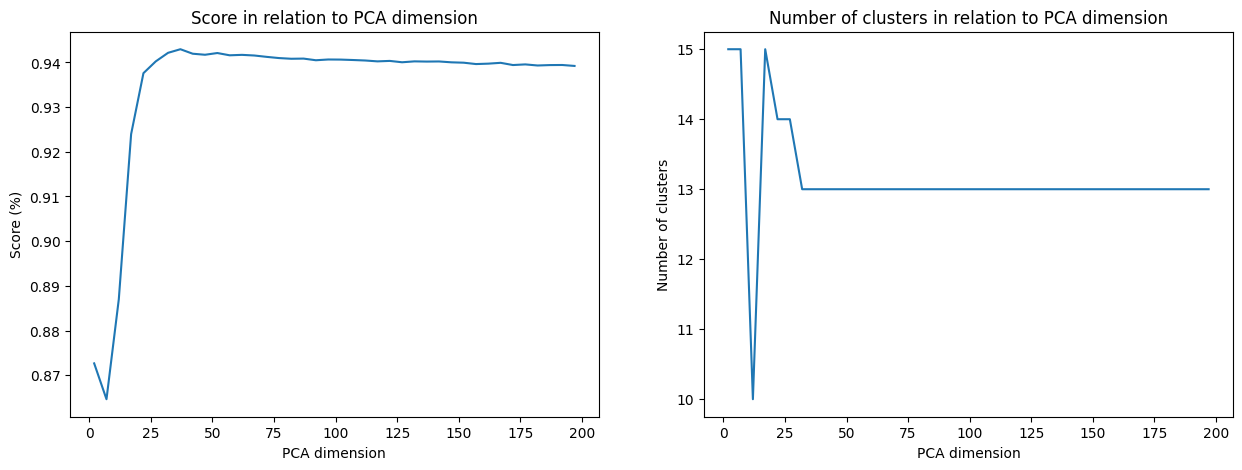

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(best_results['PCA'], best_results['score'])
ax[0].set_xlabel('PCA dimension')
ax[0].set_ylabel('Score (%)')
ax[0].set_title('Score in relation to PCA dimension')

ax[1].plot(best_results['PCA'], best_results['n_clusters'])
ax[1].set_ylabel('Number of clusters')
ax[1].set_xlabel('PCA dimension')
ax[1].set_title('Number of clusters in relation to PCA dimension')

Plot the fitting and prediction time in relation to the PCA dimension.

Text(0.5, 1.0, 'Fit and predict time in relation to PCA dimension')

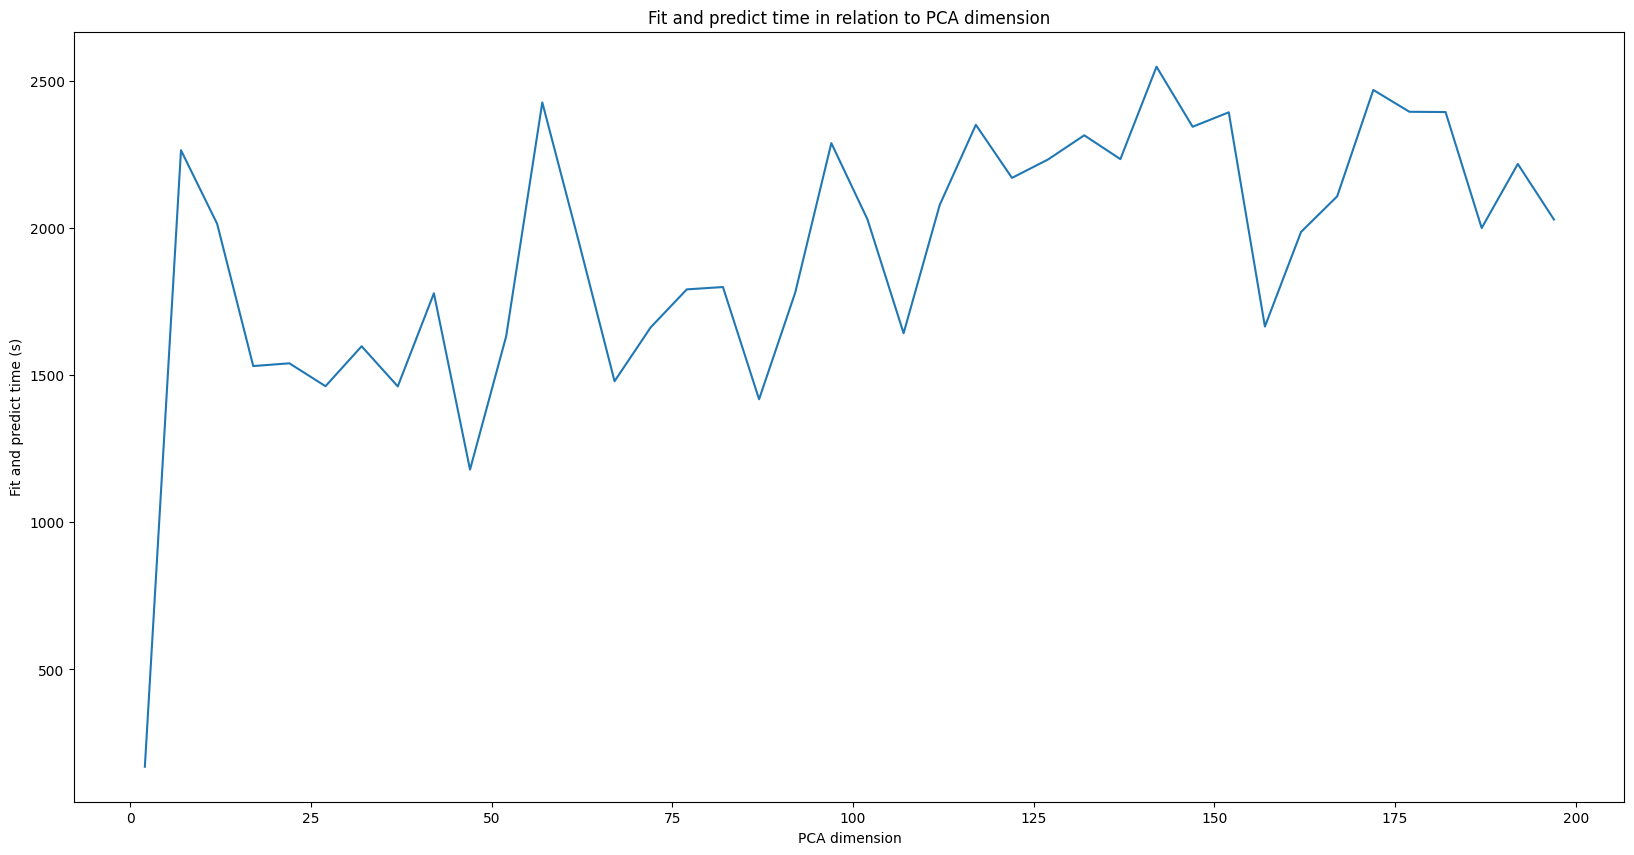

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(best_results['PCA'], best_results['fit_predict_time'])
plt.xlabel('PCA dimension')
plt.ylabel('Fit and predict time (s)')
plt.title('Fit and predict time in relation to PCA dimension')

Plotting cluster in 2 dimensions with Ellipses for the covariance.

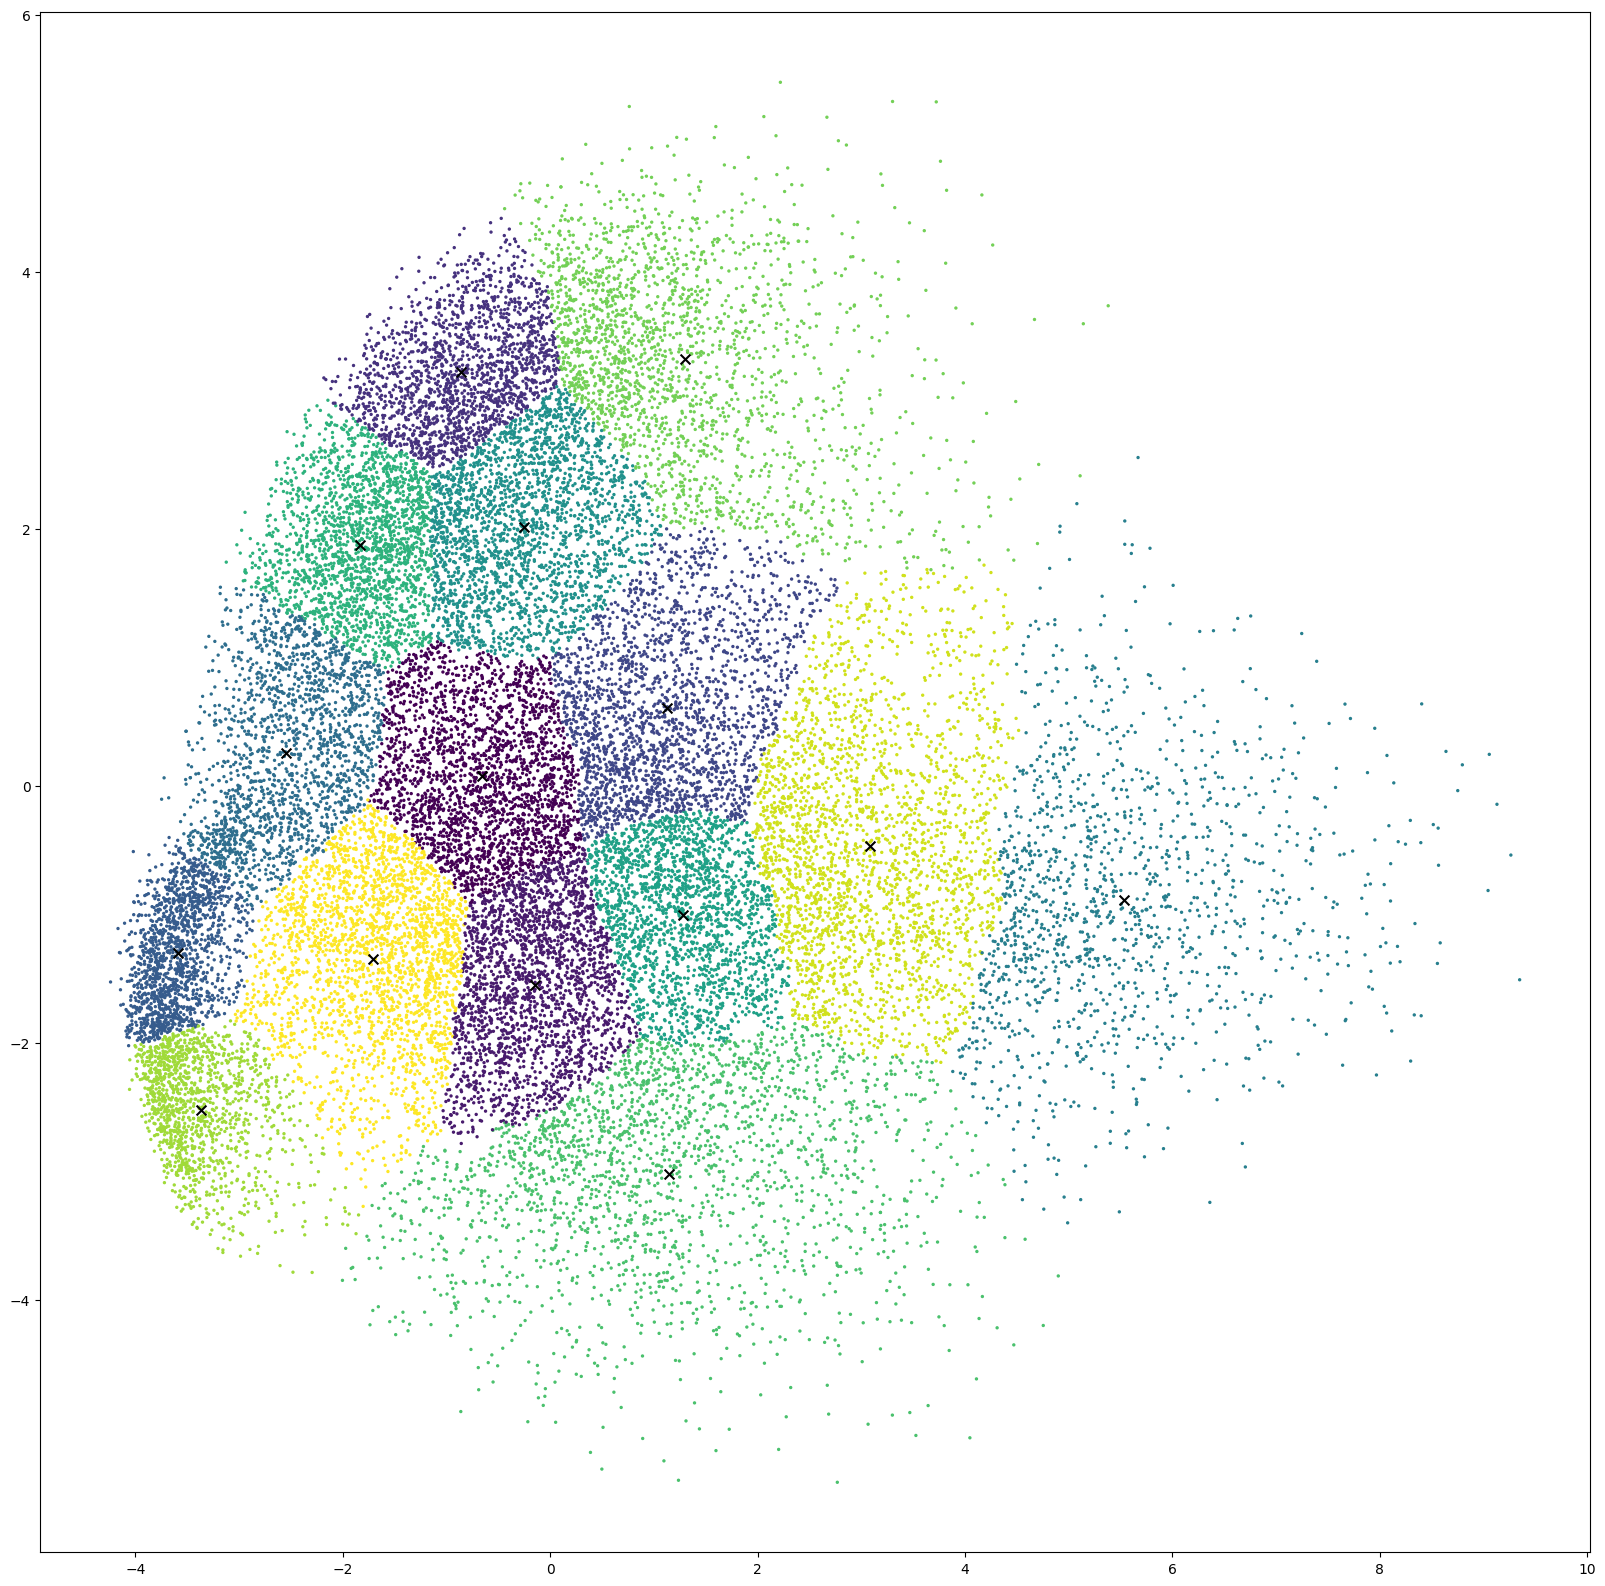

In [8]:
X = pd.read_feather('./data/pca/mnist_pca_2.feather')
# best result for PCA 2
best_res = best_results.iloc[0]
ncm = SpectralClustering(n_clusters=int(best_res['n_clusters']), affinity='nearest_neighbors', n_jobs=-1)
labels = ncm.fit_predict(X)

plt.figure(figsize=(20,20))
ax = plt.gca()
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, s=2, cmap=plt.get_cmap('viridis'), zorder=2, alpha=1)

# draw cluster centers
for cluster in np.unique(labels):
    center = X[labels == cluster].mean()
    ax.scatter(center[0], center[1], c='black', s=50, zorder=3, marker='x')

Print a latex table for the best result of each PCA dimension.

In [4]:
best_results.to_latex('./latex_res/ncm_best_results.tex', index=False)